# Поиск с учётом условий Вольфе

## Реализация одномерного поиска с учётом условий Вольфе

Напомним, что метод одномерного поиска называют удовлетворяющим сильным условиям Вольфе, если для всех выбранных им $\alpha$

1. $f(x_k + \alpha_k p_k) \le f(x_k) + c_1 \alpha_k \nabla f_k^T p_k$
2. $|\nabla f^T(x_k + \alpha_k p_k) p_k| \ge c_2 |\nabla f_k^T p_k|$
где $c_1, c_2$ - константы, такие что $0 < c_1 < c_2 < 1$

В обозначениях $\varphi(\alpha) = f(x_k + \alpha p_k)$ это равносильно

1. $\varphi(\alpha_k) \le \varphi(0) + c_1 \alpha_k \varphi'(0)$
2. $|\varphi'(\alpha_k)| \ge c_2 |\varphi'(0)|$

Для нахождения подходящего $\alpha$ воспользуемся следующим алгоритмом:
Положим $\alpha_0$ = 0, $\alpha_{max}: \varphi(\alpha_{max}) > \varphi(0) + c_1 \alpha_{max} \varphi'(0), \alpha_1 = \alpha_{max} / 2$.
И будем увеличивать $\alpha_i$, пока не получим выполнения одного из следующих условий:

1. $\varphi(\alpha_i) \le \varphi(0) + c_1 \alpha_i \varphi'(0)$ или же $\varphi(\alpha_{i}) \ge \varphi(\alpha_{i-1})$ не на первом шаге. В этом случае в качестве результата предъявим $zoom(\alpha_{i-1}, \alpha_i)$ (определение $zoom$, выбирающего точки из интервала, ограниченного $\alpha_{i-1}$ и $\alpha_i$ дадим позже).
2. $|\varphi'(\alpha_i)| \le -c_2 \varphi'(0)$. В качестве результата предъявим $\alpha_i$
3. $\varphi'(\alpha_i) \ge 0$. В качестве результата предъявим $zoom(\alpha_i, \alpha_{i-1})$
Иначе положим $\alpha_{i+1} = \frac{\alpha_{max} + \alpha_i}{2}$ и перейдём на следующую итерацию.

Уточним, как $zoom$ находит нужную нам точку.

Утверждается, что на момент вызова $zoom(\alpha_{left}, \alpha_{right})$ выполнены следующие условия:

1. Внутри интервала, ограниченного $\alpha_{left}$ и $\alpha_{right}$ существует точка, удовлетворяющая строгим условиям Вольфе.
2. $\varphi'(\alpha_{left}) (\alpha_{right} - \alpha_{left}) < 0$
3. Среди всех полученных на данный момент $\alpha$, удовлетворяющим 1 условию Вольфе значение $\varphi(\alpha_{left})$ минимально.

Сам $zoom$ выполняет следующий алгоритм:
Положим $\alpha_{mid} = \frac{\alpha_{left} + \alpha_{right}}{2}$.
Если $\varphi(\alpha_{mid}) \le \varphi(0) + c_1 \alpha_{mid} \varphi'(0)$ или $\varphi(\alpha_{mid}) \ge \varphi(\alpha_{left})$, то положим $\alpha_{right} = \alpha_{mid}$ и перейдём на следующую итерацию.
Иначе же если $|\varphi'(\alpha_{mid})| \le -c_2 \varphi'(0)$, то $\alpha_{mid}$ удовлетворяет обоим условиям Вольфе, предъявим её как результат.
Иначе $\varphi(\alpha_{mid}) (\alpha_{right} - \alpha_{left}) \ge 0$ положим $\alpha_{high} = \alpha_{low}$
В конце присвоим $\alpha_{left} = \alpha_{mid}$ и перейдём к следующей итерации.

Заметим, что инвариант из трёх условий сохраняется и после выполнения итерации, то есть он верен в начале любой итерации. Тогда при сужении интервала поиска в конце мы найдём требуемое $\alpha$.

Протестируем полученный метод линейного поиска.


Best value found: x* = [5.0000068  6.99997798] with f(x*) = 7.159784955228214e-10
Best value found: x* = [0.32269302 1.60238524] with f(x*) = -0.6574000284362631
Best value found: x* = [0.97569818 0.95179879] with f(x*) = 0.0005941186318912377


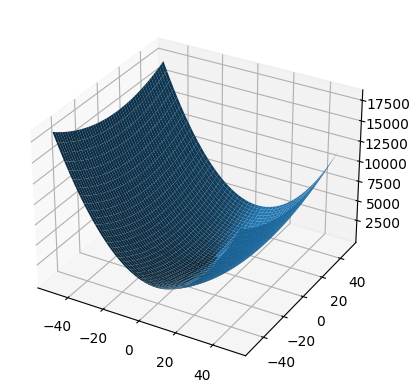

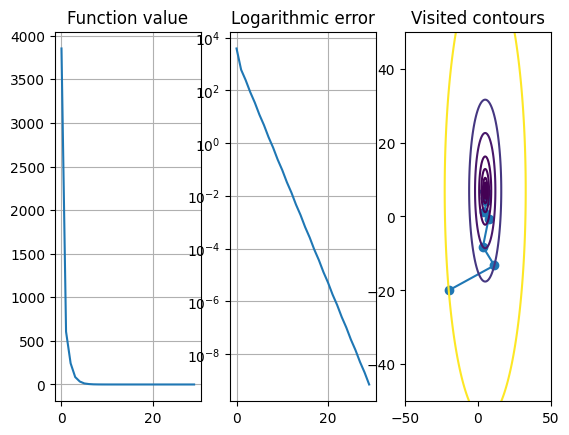

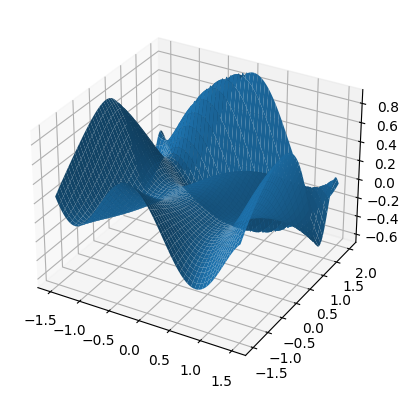

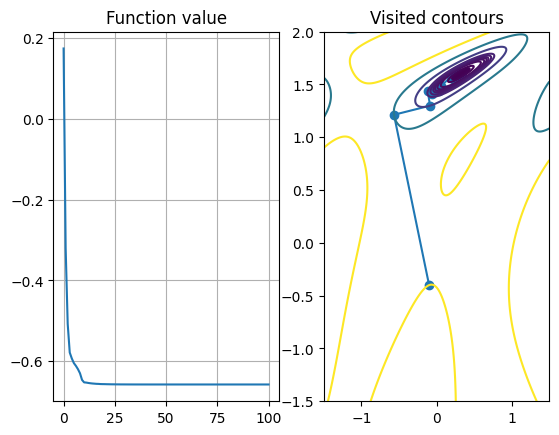

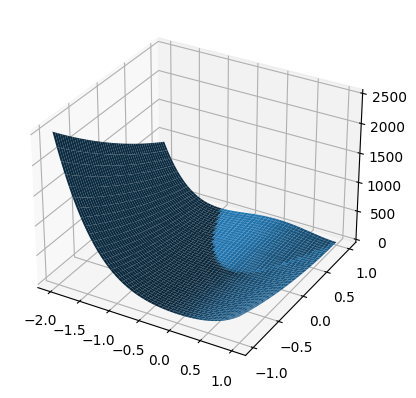

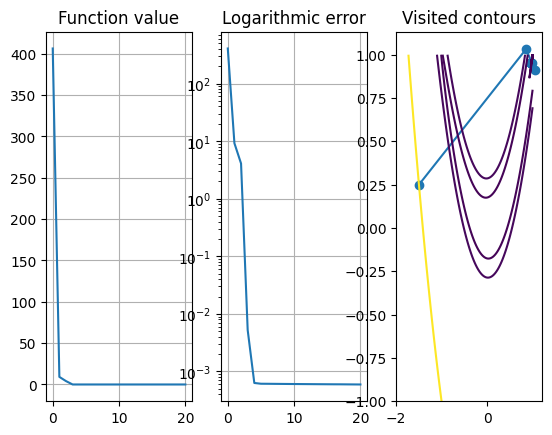

In [1]:
from core.gradient_descent import wolfe_conditions_search
from core.visualizer import test_linear_search
test_linear_search(wolfe_conditions_search(0.1, 0.9))

# Сравнение методов линейного поиска, backtracking method

## Что хотим от line search метода

Мы уже собрали целый зоопарк методов линейного поиска:
- БинПоиск по градиенту (с остановкой по достижению малого значения градиента и/или размера ворот $r - l$, с опциональным обрубанием по количеству итераций)
- Золотое сечение (по количеству итераций)
- Фибоначчи (по количеству итераций)
- Метод, базирующийся на условиях Вольфе (aka backtracking method)

Здесь нужно проанализировать, какие `line searcher`-ы _лучше_ себя показывают. Что от такого алгоритма требуется?

1. Конечно же, хорошо сходиться
2. Произвести _достаточно_ точный поиск, чтобы заЭксплойтить это направление поиска
3. Но не переусердствовать: не слишком долго искать, чтобы сэкономить время

Пункт 1 очевиден и не настолько интересен.
А вот между 2. и 3. налицо трейд-офф по поводу того, насколько быстро надо останавливаться. Для каждой конкретной функции ответ на этот вопрос разный — и хороший line search метод — тот, который хорошо умеет его давать.
Причём давать для самых разных паттернов ландшафта, масштабирований и т.д.

## Как производить оценку

Раз уж так важна устойчивость и догадливость метода, заведём набор _интересных_ функций и попробуем запустить методы на них (метод проходит все функции с одинаковыми гиперпараметрами — приближено к реальности).

Функции:
- квадратичная (какое-то/какие-то число(а) обусловленности, размерность(и))
- умножение на разные константы (маленькую, большую)/масштабирование аргументов
- непредсказуемый рельеф (всё ещё выпуклая, но где-то сильно убывает, где-то — _не очень_…)

Теперь — как оценивать результат. В целом — чем меньше действий, тем лучше. В реальной жизни обычно речь идёт о процессорном времени, но здесь измерять время — это лишняя возня, потеря точности и, главное, bias за счёт того, что у тестовых функций (к примеру, квадратичной) может быть _странное_ отношение времён вычисления функции и градиента. Это затрудняет оценку самого метода линейного поиска, а также не соответствует реальности. Поэтому будем считать, что целевая функция (чем меньше, тем лучше) в данном случае $\operatorname{computations}(f) + \operatorname{computations}(\nabla f)$.

Ожидаем, что методы с фиксированным количеством итераций будут хорошо себя проявлять только для конкретных функций фиксированного уровня сложности, а для других — либо делать избыточную работу внутри каждой итерации, либо плохо отрабатывать очередное направление → потребуется много внешних итераций, иногда даже вообще не сходиться.

А про методы с остановкой по фиксированному $\varepsilon$ ожидаем, что он будет плохо устойчив к масштабированию функции/градиента.

Реальность соответствует ожиданиям: backtracking method умеет с одной стороны вовремя остановиться, с другой — чётко отрабатывает (→ не расходится), когда это нужно.

In [80]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 10)
%load_ext autoreload
%autoreload 2

from core.gradient_descent import *
from core.visualizer import *
from core.optimizer_evaluator import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
test_linear_search(fixed_step_search(0.1), True)

Quadratic : f called 51 times, f' called 50 times, total score: 101
Trigonometric : f called 101 times, f' called 100 times, total score: 201
GD diverged at Rosenbrock (got vector norm 67215268.07617551 after 3 steps), such a pity…
GD diverged at 100-dimensional quadratic with k = 100 (got vector norm 2.4860330689387453e+18 after 16 steps), such a pity…


In [82]:
test_linear_search(fixed_step_search(1), True)

Quadratic : f called 6 times, f' called 5 times, total score: 11
Trigonometric : f called 4 times, f' called 3 times, total score: 7
GD diverged at Rosenbrock (got vector norm 697073038160.035 after 3 steps), such a pity…
GD diverged at 100-dimensional quadratic with k = 100 (got vector norm 8.738122483458636e+19 after 10 steps), such a pity…


C:\dev\Education\MethOpt\GradientDescent\core\visualizer.py:114: RuntimeWarning: overflow encountered in long_scalars
  return alpha * (x[0] - 5) ** 2 + (x[1] - 7) ** 2


In [83]:
test_linear_search(wolfe_conditions_search(0.05, 0.9), True)

Quadratic : f called 89 times, f' called 39 times, total score: 128
Trigonometric : f called 720 times, f' called 299 times, total score: 1019
Rosenbrock : f called 262 times, f' called 60 times, total score: 322
100-dimensional quadratic with k = 100 : f called 3783 times, f' called 1071 times, total score: 4854


In [84]:
test_linear_search(fibonacci_search(15), True)

Quadratic : f called 397 times, f' called 22 times, total score: 419
Trigonometric : f called 1799 times, f' called 99 times, total score: 1898
GD diverged at Rosenbrock (got vector norm 647125619911.2137 after 6 steps), such a pity…
100-dimensional quadratic with k = 100 : f called 7381 times, f' called 410 times, total score: 7791


In [85]:
test_linear_search(fibonacci_search(30), True)

Quadratic : f called 463 times, f' called 14 times, total score: 477
Trigonometric : f called 588 times, f' called 17 times, total score: 605
Rosenbrock : f called 661 times, f' called 20 times, total score: 681
100-dimensional quadratic with k = 100 : f called 12178 times, f' called 369 times, total score: 12547


In [86]:
test_linear_search(golden_ratio_search, True)

Quadratic : f called 687 times, f' called 14 times, total score: 701
Trigonometric : f called 864 times, f' called 17 times, total score: 881
Rosenbrock : f called 981 times, f' called 20 times, total score: 1001
100-dimensional quadratic with k = 100 : f called 20189 times, f' called 412 times, total score: 20601
